# Federated Learning for Acute Inflammation Dataset

The purpose of this notebook is to predict whether or not a patient has an acute inflammation condition, while also ensuring the privacy of the patient's health data through federated learning. 

In [ ]:
import urllib.request

def download_url(url, save_as):
    response = urllib.request.urlopen(url)
    data = response.read()
    file = open(save_as, 'wb')
    file.write(data)
    file.close()
    response.close()
    
def read_binary_file(file):
    f = open(file,'rb')
    block = f.read()
    return block.decode('utf-16')

def split_text_in_lines(text):
    return text.split('\r\n')

def split_by_tabs(line):
    return line.split('\t')

In [ ]:
names_link = 'https://archive.ics.uci.edu/ml/machine-learning-databases/acute/diagnosis.names'
data_link = 'https://archive.ics.uci.edu/ml/machine-learning-databases/acute/diagnosis.data'
diagnosis_names = 'diagnosis.names'
diagnosis_data = 'diagnosis.data'
download_url(names_link, diagnosis_names)
download_url(data_link, diagnosis_data)

In [ ]:
import numpy as np

def parse_double(field):
    field = field.replace(',', '.')
    return float(field)

def parse_boolean(field):
    return 1. if field == 'yes' else 0.

def read_np_array(file = diagnosis_data):
    text = read_binary_file(file)
    lines = split_text_in_lines(text)
    rows = []
    for line in lines:
        if line == '': continue
        line = line.replace('\r\n', '')
        fields = split_by_tabs(line)
        row = []
        j = 0
        for field in fields:
            value = parse_double(field) if j == 0 else parse_boolean(field)
            row.append(value)
            j += 1
        rows.append(row)
    matrix = np.array(rows, dtype = np.float32)
    return matrix


In [ ]:
def get_random_indexes(n):
    indexes = list(range(n))
    random_indexes = []
    for i in range(n):
        r = np.random.randint(len(indexes))
        random_indexes.append(indexes.pop(r))
    return random_indexes

def get_indexes_for_2_datasets(n, training = 80):
    indexes = get_random_indexes(n)
    train = int(training / 100. * n)
    return indexes[:train], indexes[train:]

matrix = read_np_array()
n_samples, n_dimensions = matrix.shape

train_indexes, test_indexes = get_indexes_for_2_datasets(n_samples)
train_data = matrix[train_indexes]
test_data = matrix[test_indexes]

def print_dataset(name, data):
    print('Dataset {}. Shape: {}'.format(name, data.shape))
    print(data)

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm as tqdm

input_size = 6
learning_rate = 0.01
num_iterations = 10000

class LogisticRegression(torch.nn.Module):

    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_size, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))


In [ ]:
def decide(y):
    return 1. if y >= 0.5 else 0.

decide_vectorized = np.vectorize(decide)

to_percent = lambda x: '{:.2f}%'.format(x)




In [ ]:
def compute_accuracy(model, input, output):
    #print(input.shape, output.shape)
    prediction = model(input).detach().numpy()
    #print(prediction.shape)
    
    #n_samples = prediction.shape[0] + 0.
    prediction = decide_vectorized(prediction)
    equal = prediction.reshape(-1,) == output.detach().numpy().reshape(-1,)
    return 100. * np.mean(equal)



In [ ]:
def get_input_and_output(data):
    input = Variable(torch.tensor(data[:, :6], dtype = torch.float32))
    output1 = Variable(torch.tensor(data[:, 6], dtype = torch.float32))
    output2 = Variable(torch.tensor(data[:, 7], dtype = torch.float32))
    return input, output1, output2

input, output1, output2 = get_input_and_output(train_data)
test_input, test_output1, test_output2 = get_input_and_output(test_data)



In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

diagnosis_title1 = 'Inflammation of Urinary Bladder'
diagnosis_title2 = 'Nephritis of Renal Pelvis Origin'

def plot_graphs(diagnosis_title, losses, accuracies):
    plt.plot(losses)
    plt.title(f"{diagnosis_title}")
    plt.xlabel("Iterations")
    plt.ylabel("Training Loss")
    plt.show()
    plt.plot(accuracies)
    plt.title(f"{diagnosis_title}")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy (Percent %)")
    plt.show()
    


In [ ]:
def train_model(diagnosis_title, input, output, test_input, test_output):
    model = LogisticRegression()
    criterion = torch.nn.BCELoss(size_average=True)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  
    losses = []
    accuracies = []
    n_samples, _ = input.shape
    for iteration in tqdm(range(num_iterations)):
            optimizer.zero_grad()
            prediction = model(input)
            #print(prediction.size(), output.size())
            loss = criterion(prediction, output)
            loss.backward()
            optimizer.step()
            if iteration % 500 == 0:
                train_acc = compute_accuracy(model, input, output)
                train_loss = loss.item()
                losses.append(train_loss)
                accuracies.append(train_acc)
                print('iteration={}, loss={:.4f}, train_acc={}'.format(iteration, train_loss, to_percent(train_acc)))
    plot_graphs(diagnosis_title, losses, accuracies)
    test_acc = compute_accuracy(model, test_input, test_output)
    print('\nTesting Accuracy = {}'.format(to_percent(test_acc)))
    return model

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
  3%|▎         | 302/10000 [00:00<00:06, 1509.73it/s]

iteration=0, loss=4.0886, train_acc=51.04%


  7%|▋         | 748/10000 [00:00<00:06, 1489.99it/s]

iteration=500, loss=1.3633, train_acc=51.04%


 12%|█▏        | 1184/10000 [00:00<00:06, 1452.68it/s]

iteration=1000, loss=0.9134, train_acc=51.04%


 17%|█▋        | 1748/10000 [00:01<00:05, 1416.23it/s]

iteration=1500, loss=0.3533, train_acc=73.96%


 22%|██▏       | 2190/10000 [00:01<00:05, 1450.30it/s]

iteration=2000, loss=0.1821, train_acc=100.00%


 28%|██▊       | 2759/10000 [00:01<00:05, 1389.65it/s]

iteration=2500, loss=0.1641, train_acc=100.00%


 32%|███▏      | 3188/10000 [00:02<00:04, 1404.36it/s]

iteration=3000, loss=0.1496, train_acc=100.00%


 36%|███▋      | 3636/10000 [00:02<00:04, 1353.66it/s]

iteration=3500, loss=0.1378, train_acc=100.00%


 42%|████▏     | 4220/10000 [00:02<00:04, 1393.13it/s]

iteration=4000, loss=0.1278, train_acc=100.00%


 47%|████▋     | 4664/10000 [00:03<00:03, 1450.83it/s]

iteration=4500, loss=0.1193, train_acc=100.00%


 53%|█████▎    | 5287/10000 [00:03<00:03, 1525.70it/s]

iteration=5000, loss=0.1119, train_acc=100.00%


 58%|█████▊    | 5783/10000 [00:03<00:02, 1571.92it/s]

iteration=5500, loss=0.1054, train_acc=100.00%


 63%|██████▎   | 6259/10000 [00:04<00:02, 1540.70it/s]

iteration=6000, loss=0.0997, train_acc=100.00%


 67%|██████▋   | 6708/10000 [00:04<00:02, 1419.96it/s]

iteration=6500, loss=0.0945, train_acc=100.00%


 73%|███████▎  | 7311/10000 [00:05<00:01, 1495.59it/s]

iteration=7000, loss=0.0899, train_acc=100.00%


 78%|███████▊  | 7760/10000 [00:05<00:01, 1458.81it/s]

iteration=7500, loss=0.0858, train_acc=100.00%


 82%|████████▏ | 8207/10000 [00:05<00:01, 1464.28it/s]

iteration=8000, loss=0.0820, train_acc=100.00%


 87%|████████▋ | 8659/10000 [00:05<00:00, 1485.21it/s]

iteration=8500, loss=0.0785, train_acc=100.00%


 93%|█████████▎| 9288/10000 [00:06<00:00, 1469.34it/s]

iteration=9000, loss=0.0753, train_acc=100.00%


 97%|█████████▋| 9740/10000 [00:06<00:00, 1492.90it/s]

iteration=9500, loss=0.0724, train_acc=100.00%


100%|██████████| 10000/10000 [00:06<00:00, 1457.62it/s]


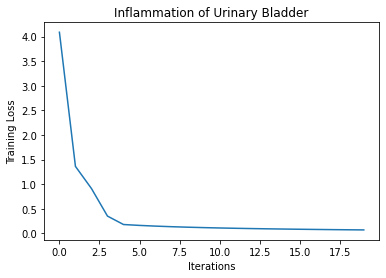

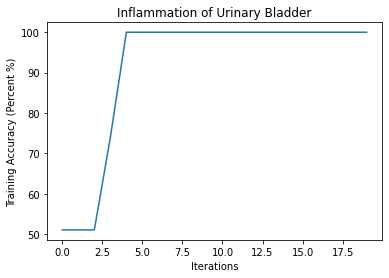


Testing Accuracy = 100.00%


In [ ]:
model = train_model(diagnosis_title1, input, output1.view(-1,1), test_input, test_output1)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
  3%|▎         | 315/10000 [00:00<00:06, 1597.73it/s]

iteration=0, loss=6.1981, train_acc=43.75%


  7%|▋         | 742/10000 [00:00<00:06, 1447.94it/s]

iteration=500, loss=1.7224, train_acc=43.75%


 12%|█▏        | 1168/10000 [00:00<00:06, 1439.42it/s]

iteration=1000, loss=1.2993, train_acc=43.75%


 18%|█▊        | 1760/10000 [00:01<00:05, 1467.55it/s]

iteration=1500, loss=0.8150, train_acc=52.08%


 22%|██▏       | 2213/10000 [00:01<00:05, 1433.34it/s]

iteration=2000, loss=0.2870, train_acc=85.42%


 28%|██▊       | 2788/10000 [00:01<00:05, 1420.96it/s]

iteration=2500, loss=0.1887, train_acc=100.00%


 32%|███▏      | 3248/10000 [00:02<00:04, 1488.51it/s]

iteration=3000, loss=0.1732, train_acc=100.00%


 37%|███▋      | 3693/10000 [00:02<00:04, 1423.42it/s]

iteration=3500, loss=0.1604, train_acc=100.00%


 43%|████▎     | 4298/10000 [00:02<00:03, 1495.03it/s]

iteration=4000, loss=0.1497, train_acc=100.00%


 48%|████▊     | 4751/10000 [00:03<00:03, 1485.50it/s]

iteration=4500, loss=0.1405, train_acc=100.00%


 52%|█████▏    | 5204/10000 [00:03<00:03, 1490.30it/s]

iteration=5000, loss=0.1325, train_acc=100.00%


 57%|█████▋    | 5656/10000 [00:03<00:02, 1474.02it/s]

iteration=5500, loss=0.1254, train_acc=100.00%


 63%|██████▎   | 6256/10000 [00:04<00:02, 1484.02it/s]

iteration=6000, loss=0.1192, train_acc=100.00%


 67%|██████▋   | 6701/10000 [00:04<00:02, 1437.62it/s]

iteration=6500, loss=0.1136, train_acc=100.00%


 71%|███████▏  | 7145/10000 [00:04<00:01, 1428.39it/s]

iteration=7000, loss=0.1085, train_acc=100.00%


 78%|███████▊  | 7766/10000 [00:05<00:01, 1485.27it/s]

iteration=7500, loss=0.1039, train_acc=100.00%


 82%|████████▏ | 8220/10000 [00:05<00:01, 1496.13it/s]

iteration=8000, loss=0.0997, train_acc=100.00%


 87%|████████▋ | 8678/10000 [00:05<00:00, 1508.21it/s]

iteration=8500, loss=0.0958, train_acc=100.00%


 93%|█████████▎| 9302/10000 [00:06<00:00, 1542.43it/s]

iteration=9000, loss=0.0923, train_acc=100.00%


 98%|█████████▊| 9764/10000 [00:06<00:00, 1489.79it/s]

iteration=9500, loss=0.0890, train_acc=100.00%


100%|██████████| 10000/10000 [00:06<00:00, 1464.37it/s]


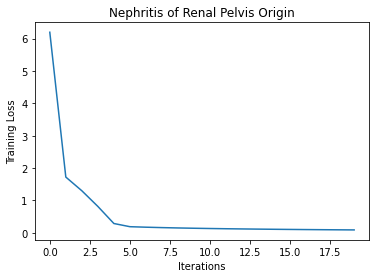

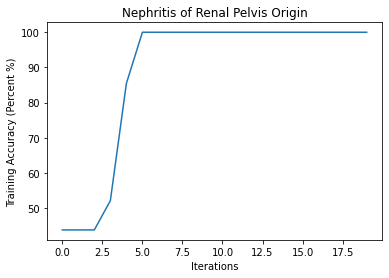


Testing Accuracy = 100.00%


In [ ]:
model = train_model(diagnosis_title2, input, output2.view(-1,1), test_input, test_output2)

## Implementing Federated Learning with FedAvg Algorithm

In [ ]:
assert True is True

In [ ]:
!pip install syft=="0.2.2a1"
!pip install syft_proto=="0.1.1a1.post17"

     |████████████████████████████████| 337kB 5.0MB/s 
     |████████████████████████████████| 532kB 9.9MB/s 
     |████████████████████████████████| 71kB 6.1MB/s 
     |████████████████████████████████| 2.1MB 17.0MB/s 
     |████████████████████████████████| 1.8MB 28.8MB/s 
     |████████████████████████████████| 112kB 51.9MB/s 
     |████████████████████████████████| 10.2MB 48.2MB/s 
     |████████████████████████████████| 773.1MB 22kB/s 
     |████████████████████████████████| 71kB 7.3MB/s 
     |████████████████████████████████| 61kB 6.5MB/s 
     |████████████████████████████████| 61kB 6.9MB/s 
  Created wheel for zstd: filename=zstd-1.5.0.2-cp37-cp37m-linux_x86_64.whl size=1672601 sha256=e8ccf1756cc80faa173df3773e91440f29d04ee9f84a762c71dd0b1bda48d4f6
  Stored in directory: /root/.cache/pip/wheels/de/94/60/9664cd21af20b4d63068fd1b6271951207947cd1a4085fcf97
  Created wheel for phe: filename=phe-1.4.0-py2.py3-none-any.whl size=37362 sha256=aa868470724b8f44488ac18510152c5713c0ff1524

     |████████████████████████████████| 40kB 3.4MB/s 
  Found existing installation: syft-proto 0.5.3
    Uninstalling syft-proto-0.5.3:
      Successfully uninstalled syft-proto-0.5.3


In [ ]:
import sys
import pytest
import syft as sy

In [ ]:
import torch as th
hook = sy.TorchHook(th)
from torch import nn, optim

In [ ]:
n_hospitals = 2
hospitals = []
for i in range(n_hospitals):
    hospital_name = 'hospital{}'.format(i)
    hospital = sy.VirtualWorker(hook, id = hospital_name)
    hospitals.append(hospital)
secure_worker = sy.VirtualWorker(hook, id="secure_worker")

In [ ]:
def get_workers_names(workers):
    return [worker.id for worker in workers]

In [ ]:
def add_and_print_workers(worker, workers):
    print('workers of {} = {}'.format(worker.id, get_workers_names(workers)))
    worker.add_workers(workers)

In [ ]:
for i in range(n_hospitals):
    workers = [hospitals[i2] for i2 in range(n_hospitals) if i2 != i] + [secure_worker]
    add_and_print_workers(hospitals[i], workers)
add_and_print_workers(secure_worker, hospitals)

Worker hospital1 already exists. Replacing old worker which could cause                     unexpected behavior
Worker secure_worker already exists. Replacing old worker which could cause                     unexpected behavior
Worker hospital0 already exists. Replacing old worker which could cause                     unexpected behavior
Worker secure_worker already exists. Replacing old worker which could cause                     unexpected behavior
Worker hospital0 already exists. Replacing old worker which could cause                     unexpected behavior
Worker hospital1 already exists. Replacing old worker which could cause                     unexpected behavior


workers of hospital0 = ['hospital1', 'secure_worker']
workers of hospital1 = ['hospital0', 'secure_worker']
workers of secure_worker = ['hospital0', 'hospital1']


In [ ]:
n_samples = train_data.shape[0]
samples_per_hospital = int((n_samples + 0.5) / n_hospitals)
hospital_features = []
hospital_targets1 = []
hospital_targets2 = []
train_data = th.tensor(train_data, dtype = torch.float32, requires_grad=True)
for i in range(n_hospitals):
    train_data2 = train_data[i * samples_per_hospital:(i + 1) * samples_per_hospital].clone().detach().requires_grad_(True)
    features = train_data2[:, :6].clone().detach().requires_grad_(True)
    targets1 = train_data2[:, 6][:, None].clone().detach() 
    targets2 = train_data2[:, 7][:, None].clone().detach() 
    hospital_features.append(features.send(hospitals[i]))
    hospital_targets1.append(targets1.send(hospitals[i]))
    hospital_targets2.append(targets2.send(hospitals[i]))

print(model)

LogisticRegression(
  (linear): Linear(in_features=6, out_features=1, bias=True)
)


In [ ]:
def plot_federated_graphs(diagnosis_title, losses, accuracies):
    for i in range(n_hospitals):
        plt.plot(losses[i], label=f'Hospital {i}')
    legend = plt.legend(loc='upper right', shadow=True)
    plt.title(f"{diagnosis_title}")
    plt.xlabel("Iterations")
    plt.ylabel("Training Loss")
    plt.show()
    for i in range(n_hospitals):
        plt.plot(accuracies[i], label=f'Hospital {i}')
    legend = plt.legend(loc='lower right', shadow=True)
    plt.title(f"{diagnosis_title}")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy (%)")
    plt.show()
    

In [ ]:
def compute_federated_accuracy(model, input, output):
    prediction = model(input)
    n_samples = prediction.shape[0]
    s = 0.
    for i in range(n_samples):
        p = 1. if prediction[i] >= 0.5 else 0.
        e = 1. if p == output[i] else 0.
        s += e
    return 100. * s / n_samples


In [ ]:
iterations = 100 #2000
worker_iterations = 100

def federated_learning(diagnosis_title, hospital_features, hospital_targets, test_input, test_output):
    model = LogisticRegression()
    criterion = torch.nn.BCELoss(size_average=True)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  
    losses = [[] for i in range(n_hospitals)]
    accuracies = [[] for i in range(n_hospitals)]
    for iteration in range(iterations):
        models = [model.copy().send(hospitals[i]) for i in range(n_hospitals)]
        optimizers = [torch.optim.SGD(params = models[i].parameters(), lr = learning_rate) for i in range(n_hospitals)]
        for worker_iteration in range(worker_iterations):
            last_losses = []
            for i in range(n_hospitals):
                optimizers[i].zero_grad()
                prediction = models[i](hospital_features[i])
                loss = criterion(prediction, hospital_targets[i])
                loss.backward()
                optimizers[i].step()
                loss = loss.get().data.item()
                last_losses.append(loss)
        for i in range(n_hospitals):
            losses[i].append(last_losses[i])
            train_acc = compute_federated_accuracy(models[i], hospital_features[i], hospital_targets[i])
            accuracies[i].append(train_acc)
            models[i].move(secure_worker)
        with th.no_grad():
            avg_weight = sum([models[i].linear.weight.data for i in range(n_hospitals)]) / n_hospitals
            model.linear.weight.set_(avg_weight.get())
            avg_bias = sum([models[i].linear.bias.data for i in range(n_hospitals)]) / n_hospitals
            model.linear.bias.set_(avg_bias.get())
        if iteration % 10 == 0:
            losses_str = ['{:.4f}'.format(losses[i][-1]) for i in range(n_hospitals)]
            accuracies_str = [to_percent(accuracies[i][-1]) for i in range(n_hospitals)]
            print('Iteration={}, losses={}, accuracies={}'.format(iteration, losses_str, accuracies_str))
    plot_federated_graphs(diagnosis_title, losses, accuracies)
    test_acc = compute_accuracy(model, test_input, test_output)
    print('\nTesting Accuracy = {}'.format(to_percent(test_acc)))
    return model

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Iteration=0, losses=['2.0394', '0.7123'], accuracies=['41.67%', '60.42%']
Iteration=10, losses=['0.9124', '0.5001'], accuracies=['54.17%', '60.42%']
Iteration=20, losses=['0.1647', '0.1788'], accuracies=['97.92%', '100.00%']
Iteration=30, losses=['0.1360', '0.1495'], accuracies=['100.00%', '100.00%']
Iteration=40, losses=['0.1167', '0.1287'], accuracies=['100.00%', '100.00%']
Iteration=50, losses=['0.1026', '0.1132'], accuracies=['100.00%', '100.00%']
Iteration=60, losses=['0.0917', '0.1010'], accuracies=['100.00%', '100.00%']
Iteration=70, losses=['0.0831', '0.0911'], accuracies=['100.00%', '100.00%']
Iteration=80, losses=['0.0761', '0.0831'], accuracies=['100.00%', '100.00%']
Iteration=90, losses=['0.0702', '0.0763'], accuracies=['100.00%', '100.00%']


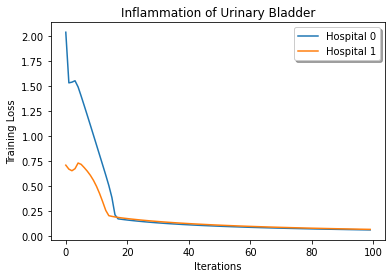

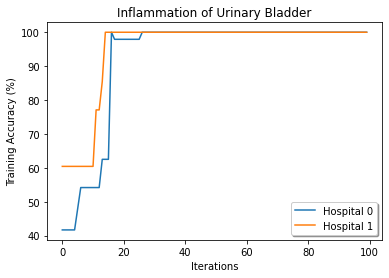


Testing Accuracy = 100.00%


In [ ]:
model = federated_learning(diagnosis_title1, hospital_features, hospital_targets1, test_input, test_output1)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Iteration=0, losses=['1.1681', '0.8635'], accuracies=['54.17%', '66.67%']
Iteration=10, losses=['1.3158', '0.5268'], accuracies=['45.83%', '66.67%']
Iteration=20, losses=['0.5346', '0.1829'], accuracies=['62.50%', '100.00%']
Iteration=30, losses=['0.1831', '0.1520'], accuracies=['100.00%', '100.00%']
Iteration=40, losses=['0.1595', '0.1329'], accuracies=['100.00%', '100.00%']
Iteration=50, losses=['0.1418', '0.1183'], accuracies=['100.00%', '100.00%']
Iteration=60, losses=['0.1278', '0.1069'], accuracies=['100.00%', '100.00%']
Iteration=70, losses=['0.1166', '0.0976'], accuracies=['100.00%', '100.00%']
Iteration=80, losses=['0.1073', '0.0898'], accuracies=['100.00%', '100.00%']
Iteration=90, losses=['0.0994', '0.0833'], accuracies=['100.00%', '100.00%']


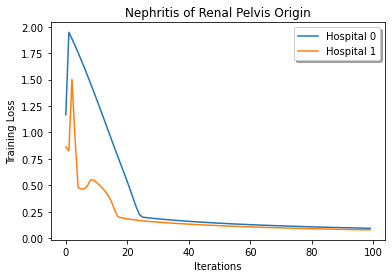

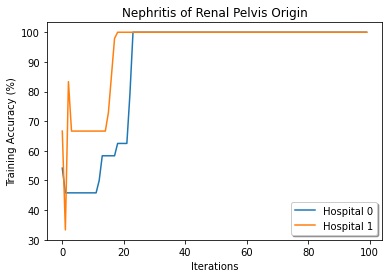


Testing Accuracy = 100.00%


In [ ]:
model = federated_learning(diagnosis_title2, hospital_features, hospital_targets2, test_input, test_output2)